# 所得分布と所得収斂

If you come here without expecting Japanese, please click [Google translated version](https://translate.google.com/translate?sl=auto&tl=en&u=https://py4macro.github.io/7_Distribution.html) in English or the language of your choice.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib
import py4macro

## はじめに

[発展会計と成長会計](chap:5-accounting)の章では次の２つの問題を考察した。

> （問１）なぜある国は豊かで他の国は貧しいのだろうか？
>
> （問２）なぜ国々の経済成長率は大きく異なるのか？

ここでは関連する次の問を考える。

> （問３）貧しい国は豊かな国に追いついているのだろうか？

この問いを考察するために２つのアプローチを使う。第一に，一人当たりGDPを使い世界経済の所得分布がどのように変化したかを図示し検討する。所得分布の形状の変化からキャッチアップ（catch-up）が発生しているかを推論しようということである。第二に，回帰分析の手法を使い所得が低い経済は先進国に追いついているかを検討する。即ち，所得収斂が起こっているかを定量的に探ってみようということである。

## 所得分布の推移

(sec:7-distribution)=
## 所得分布の推移

世界経済の所得分布が時間と共にどのように変化したかを考えるが，手法としては，一人当たりGDPの分布自体の変化を図示して確認する。分析に使うデータはPenn World Talbeの次の２変数：
* `rgdpe`：支出面から計算したGDP（連鎖PPPs; in mil. 2017US\$）
    * 経済間そして時系列的にも一定な価格を使い計算されてい「実質」
    * 経済間そして時間の次元での比較に適している
* `pop`：人口（in millions）

これらのデータを使い，所得分布のヒストグラムとカーネル密度推定に基づくプロットを説明する。まず，一人当たりGDPの変数（対数）を作成する。

In [2]:
# Penn World Tableのデータ
df = py4macro.data('pwt')

# 一人当たりGDP（対数）
df['gdp_pc_log'] = np.log( df['rgdpe'] / df['pop'] )

例として2019年の日本の一人当たりGDPを表示してみよう。

In [3]:
y_jp = df.query('country == "Japan" & year == 2019')['gdp_pc_log']
y_jp

6159    10.587516
Name: gdp_pc_log, dtype: float64

このコードで返されるのは`Series`なので，`gdp_pc_log`の値自体を抽出するためには`.iloc[]`を使う。

In [4]:
y_jp.iloc[0]

10.587515569810463

次に2019年のヒストグラムを作成しよう。

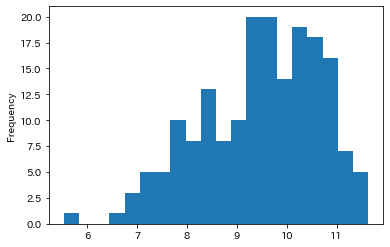

In [5]:
df.query('year == 2019')['gdp_pc_log'].plot(kind='hist', bins=20)
pass

ヒストグラムは縦軸に度数，横軸に階級を取ったグラフだが，関連する手法に[カーネル密度推定](https://en.wikipedia.org/wiki/Kernel_density_estimation)と呼ばれるものがある。考え方は簡単で，上のようなヒストグラムのデータに基づき面積が１になるようにスムーズな分布を推計する手法である。詳細は割愛するが，下のコードではヒストグラムとカーネル密度関数を重ねてプロットする。

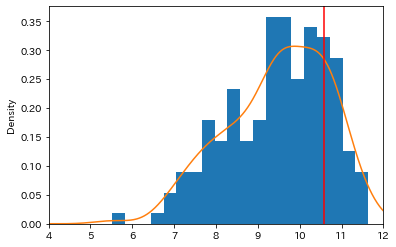

In [6]:
# ヒストグラム
ax_ = df.query('year == 2019')['gdp_pc_log'].plot(kind='hist', bins=20, density=True)

# 密度関数
df.query('year == 2019')['gdp_pc_log'].plot(kind='density',ax=ax_)

# 日本
ax_.axvline(y_jp.iloc[0],color='red')

# 横軸の表示範囲
ax_.set_xlim(4,12)
pass

```{admonition} コードの説明
* `density=True`は縦軸を確率として表示する引数
* `kind='density'`は分布のスムーズな形を推定し表示する引数（密度関数を推定する）
* `axvline()`は`ax_`のメソッドであり，横軸の第一引数の値に垂直線を表示する。`color`は色を指定する引数。
* `set_xlim()`は横軸の表示範囲を指定する。
```

最頻値（モード）は中心より右側にあるが，横軸は対数になっていることを思い出そう。対数を取らない分布では，最頻値は分布の中心より左側に位置することになる。試してみよう。

ここで確かめたいのは，約70年の間に上の所得分布のどのように変化してきたか，という問題である。この問いに答えるために，カーネル密度関数（`kind=density`）を使って1950年から10年毎の分布を表示する。

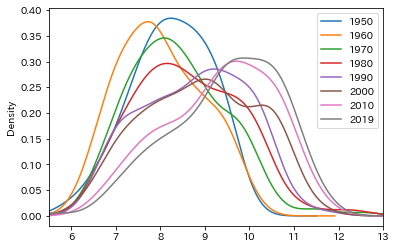

In [7]:
yr_list = list(range(1960,2020,10))+[2019]           # (1)

cond = ( df.loc[:,'year'] == 1950 )                  # (2)
ax_ = df.loc[cond,'gdp_pc_log'].plot(kind='density', # (3)
                                     label='1950',   # (4)
                                     legend=True)    # (5)
for y in yr_list:                                    # (6)
    cond = ( df.loc[:,'year'] == y )                 # (7)
    df.loc[cond,'gdp_pc_log'].plot(kind='density',   # (8)
                                   label=str(y),     # (9)
                                   legend=True,      # (10)
                                   ax=ax_)           # (11)
ax_.set_xlim([5.5,13.0])                             # (12)
pass

```{admonition} コードの説明
(1) `range(start, end, step)`は`start`から`end`までの整数を`step`の間隔で準備する。更に`list()`を使ってリストに変換し，`+[2019]`を使ってリストの最後に`2019`を追加している。

(2) 列`year`が`1950`と等しい行が`True`，そうでない行は`False`となる`Series`を`cond`に割り当てる。

(3) 1950年の行を抽出し，密度関数を表示する。また，その「軸」を`ax_`に割り当てる。

(4) 凡例の表示を`'1950'`（文字列）とする。

(5) 凡例の表示を指定する。

(6) `yr_list`に対しての`for`ループで1960から10年毎のループの開始。

(7) 列`year`が`y`と等しい行が`True`，そうでない行は`False`となる`Series`を`cond`に割り当てる。(2)で設定した`cond`は上書きされる。

(8) `y`の行を抽出し，密度関数を表示する。

(9) 凡例の表示を文字列に変換した`y`とする。`str()`は文字列に変換する関数。

(10) 凡例の表示を指定する。

(11) 「軸」を選ぶ引数`ax`には`ax_`を指定する。

(12) `ax_`のメソッドである`set_xlim()`は横軸の表示範囲を指定する。
    * 最小値，最大値をリストもしくはタプルで指定する。
    * `set_xlim()`が設定されない場合は，自動で設定される。
```

まず分布は左から右に移動しているが，これは世界経済が成長している結果である。次に気づくのが，分布が左に偏っているが少しずつ右への偏りに変化しているように見える。これを数値として確かめるために歪度（わいど; skewness）という概念を使おう。歪度は平均や標準偏差のように簡単に計算できる統計量であり，次のように定義される。

$$
G=\frac{n}{(n-1)(n-2)}
    \sum_{i=1}^n
    \left(
        \frac{
            x-\overline{x}
            }{s}
    \right)^3
$$

ここで$n$は標本の大きさ，$\overline{x}$は標本平均，$s$は標本標準偏差である。{numref}`fig:7-skewness`を使って歪度を説明しよう。
* $G>0$：「正の歪み」がある分布と呼ばれる。
    * 「左に偏った」とも呼ばれる。
    * 紛らわしいが，右裾が長くなっているため「右の歪み」とも呼ばれる。
* $G<0$：「負の歪み」がある分布と呼ばれる。
    * 「右に偏った」とも呼ばれる。
    * 紛らわしいが，左裾が長くなっているため「左の歪み」があるとも呼ばれる。
* $G=0$：左右対称分布

```{figure} /images/skewness.jpeg
---
scale: 25%
name: fig:7-skewness
---
Gの符号と分布の歪み（偏り）の関係
```

もしキャッチアップが起こると，一人当たりGDPが低い経済はより高い所得を得る経済に近づき，所得が比較的に高い国が増えることになる。従って，キャッチアップによって$G$は減少すると考えられる。歪度の推移を計算してみよう。

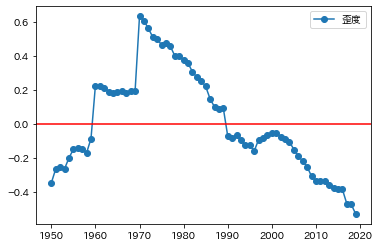

In [8]:
year_list = df.loc[:,'year'].unique()

skew_list = []

for yr in year_list:                       # (1)
    
    cond = ( df.loc[:,'year']==yr )        # (2)
    s = df.loc[cond, 'gdp_pc_log']         # (3)
    
    # 歪度
    skew_val = s.skew()                    # (4)
    skew_list.append( skew_val )           # (5)

ax_ = pd.DataFrame({'歪度':skew_list},      # (6)
                   index=year_list) \
                  .plot(marker='o')        # (7)
ax_.axhline(0, color='red')                # (8)
pass

```{admonition} コードの確認
(1) `year_list`に対して`for`ループの開始。

(2) 列`year`が`yr`と同じ場合は`True`となり，そうでない場合は`False`となる`Series`を返し`cond`に割り当てる。

(3) 列`gdp_pc_lo`で`cond`がTrue`となる行を`Series`として抽出し`s`に割り当てる。

(4) `s`のメソッド`.skew()`を使い，`s`の歪度を計算し`skew_val`に割り当てる。

(5) `skew_val`を`skew_list`に割り当てる。

(6) `skew_list`からなる`DataFrame`を作成し，`year_list`を行インデックスに指定する。また(8)で`.plot()`によって生成される「軸」を`ax_`に割り当てる。

(7) プロットのマーカーを`'o'`（点）に指定する。

(8) `ax_`のメソッド`.axhline()`を使い`0`に赤の横線を引く。
```

次の特徴がある。
1. 1970年以降は減少トレンドが確認できる。このことからキャッチアップが発生していることを示唆している。また1990年頃を境に「正の歪み」から「負の歪み」に変化している。
1. 1960年，1970年，1990年に上方・下方ジャンプが発生している。これは以下で確認するように，`gdp_pc_log`が`NaN`ではない国数が大きく増加しているためである。
1. 1970年前だけを考えると，歪度は上昇トレンドとなっている。これも欠損値がない国数の変化による影響とも考えられる。

これらの点を考えるために`gdp_pc_log`が`NaN`ではない国数を確認しよう。次のコードは，2019年に`gdp_pc_log`が欠損値ではない国数を返している。

In [78]:
cond = ( df.loc[:,'year']==2019 )
df.loc[cond,'gdp_pc_log'].notna().sum()

183

```{admonition} コードの説明
* `notna()`は要素が`NaN`かどうかを調べるメソッドである。要素が`NaN`でなければ`True`を返し，`NaN`であれば`False`を返す。`notna`は英語の`not na`のことであり，`na`は`not available`の略で欠損値のこと。
* `True`は`1`と数えられるので，メソッド`sum()`を使うことにより`True`の数，即ち，`NaN`ではない要素の数を返す。
```

次に`for`ループを使って全ての年で`gdp_pc_log`に欠損値ない国の数を確認してみる。

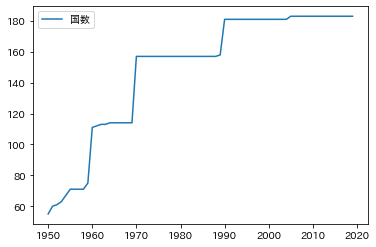

In [10]:
notna_list = []

for yr in year_list:
    cond = ( df.loc[:,'year']==yr )                # (1)
    no = df.loc[cond, 'gdp_pc_log'].notna().sum()  # (2)
    notna_list.append(no)

pd.DataFrame({'国数':notna_list}, index=year_list).plot()
pass

```{admonition} コードの説明
(1) 列`year`が`yr`と等しい行が`True`となり，そうでない行は`False`となる`Series`を返す。

(2) `gdp_pc_log`の列で`cond`が`True`の行を`Series`としてを返す。そのメソッド`.notna()`は欠損値でない場合は`True`を返し，欠損値の場合は`False`を返す。`.sum()`は`True`の数を返し`no`に割り当てる。
```

上の図から`gdp_pc_log`が欠損値でない国は増加しており，1960年，1970年，1990年に大きく増えている。データが整備されている国は典型的に先進国であり，後から含まれる国は比較的に所得が低い経済である。従って，貧しい国が所得分布に含まれることにより，分布は左側に引っ張られる傾向にある。特に，1950年から1960年には徐々に国数は増えているが，それが歪度の上昇につながっていると考えられる。また1960年と1970年の国数の急激な増加が歪度の上方ジャンプとして現れている。このようなことから，1970年までの歪度の上昇トレンドは，貧しい経済がPWTのデータセットに含まれることによって引き起こされており，豊かな国と比較して貧しい国が引き離されているからではない。一方で，1970年以降も国数は膨らんでいるが，それにも関わらず歪度は減少傾向を示しているということはキャッチアップが発生していることを示している。典型的な例は，台湾，シンガポール，香港，韓国，中国やインドなどである。

分布の形の変化を確認するために歪度を使ったが，キャッチアップを捉える統計量として変動係数を考えてみよう。変動係数は分布の広がりを示す統計量であり，次のように定義される。

$$
\text{変動係数（Coefficient of Variation）}＝\dfrac{\text{標準偏差}}{\text{平均}}
$$

変動係数は平均値１単位あたりの標準偏差を表しており，平均値を使って標準化することにより分布の幅の程度を比べることが可能となる。キャッチアップにより経済間お所得格差を示す変動係数は減少するのではないかと思われる。次のコードで変動係数の推移を計算してみよう。

In [11]:
cv_list = []   # 空のリスト

for yr in year_list:
    cond = ( df.loc[:,'year']==yr )
    s = df.loc[cond, 'gdp_pc_log']
    stdev = s.std()                 # (1)
    avr = s.mean()                  # (2)
    cv = stdev / avr                # (3)
    cv_list.append(cv)

df_cv = pd.DataFrame({'CV':cv_list}, index=year_list)  # (4)

```{admonition} コードの説明
(1) `s`は`cond`の条件を満たす`gdp_pc_log`の列の要素からなる`Series`だが，そのメソッド`.std()`を使い標準偏差を計算し`stdev`に割り当てる。

(2) `s`のメソッド`.mean()`を使い平均を計算し`avr`に割り当てる。

(3) 変動係数を計算し`cv`に割り当てる。

(4) `index=year_list`は行インデックスにyear_listを設定しており，それにより，次のコードでは自動的に横軸が年になる。
```

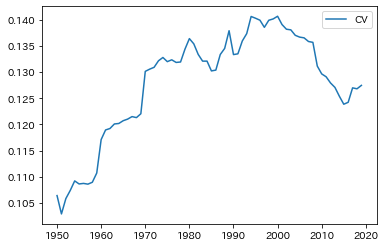

In [12]:
df_cv.plot()
pass

サンプルに含まれる国数が徐々に増えており，その影響により変動係数は増える傾向にある。1990年ごろにはデータセットに含まれる国数は安定し，その後直ぐに変動係数は減少し始めている。即ち，少なくとも1990年代半ば頃から経済間の所得格差は減少している。変動係数を見る限りキャッチアップの効果が1990年代から現れていると言える。

上で扱った変動係数は経済間における所得格差を表す指標として解釈することができるが，その場合次の点に注意する必要がある。
* 分析の対象は国であり，それぞれの国の一人当たりGDPのみを考えた。中国やインドのように大きな国も，ルクセンブルクやシンガポールのように小さな国も１つの経済として扱っている。この場合の変動係数は，全ての国には一人だけしか住んでいないと仮定した場合の経済間の所得格差と同じであり，**国内**の人口や所得不平等やは全く考慮されていない。

## 所得収斂

### 説明

ここでは問３を回帰分析の手法に基づき検討する。では問３を捉えるにはどのような回帰式になれば良いだろうか？それを考えるために，高校体育の10km持久走を思い出してみよう。スタートして１０分程経つと，先頭を走る学生とタラタラ走る学生などに別れるのが通常のパターンだと思うが，後ろの集団にＡ君が混じっているとしよう。そして，ある時点でＡ君は先頭に追いつこうと決心して真面目に走り出し，身体能力が高いＡ君はゴール寸前で先頭集団に追いつき，晴れて１位になれたとしよう。

この場合，次の関係が成立する必要がある。
* Ａ君が決心した時点までの間，Ａ君が走った距離は先頭集団が走った距離より**短い**。しかしＡ君が決心した後，ゴールするまでのＡ君の平均速度は先頭集団よりも**速かった**。

一方，追いつかれた先頭集団から見ると次の関係が成立している。
* Ａ君が決心した時点までの間，先頭集団が走った距離はＡ君が走った距離より**長い**。しかしＡ君が決心した後，ゴールするまでの先頭集団の平均速度はＡ君よりも**遅かった**。

まとめると，Ａ君が優勝するには，決心した時までに走った距離とその後の平均速度との間には**負の関係**が存在しているということだ。重要な点として，Ａ君が優勝しなかったとしても，先頭集団との距離を縮めてゴールしたのであれば，同じように負の関係が成立することが挙げられる。

この関係を問３に当てはめてみよう。1980年の一人当たりGDPは米国よりも低いＡ国を例にとすると，その後の40年間の成長率を比べると次のことが言える。
* Ａ国の成長率が米国を上回っていれば，米国にキャッチアップ（catch-up）している。
* Ａ国の成長率が米国を下回っていれば，米国に引き離されているしている（fall behind）。

この点を捉えるために次の推定式が想定できる。

$$
(\text{平均成長率})_i = a + b\times(\text{初期時点の一人当たりGDP})_i + u_i
$$

ここで$i$は経済を表している。推定値$\hat{b}$がマイナスであれば，キャッチアップが起こっていることが確認できることになる。実際にデータを扱う前に次を定義する。

**＜無条件所得収斂＞**
> 一人当たり所得の成長率は，初期時点での一人当たり所得と反比例する。

### データ

ここではPenn World Talbe 10.0の次の変数を使う。

* `rgdpna`：平均成長率の計算に使う
* `cgdpe`：初期時点の一人当たりGDPの計算に使う
* `csh_i`：貯蓄率の計算に使う
* `pop`：人口（in millions）
* `regions`：6つの地域
    * North America, Africa, Europe, Asia, South America,Australia
* `income_group_wb`：所得水準位よる4つのグループ（世界銀行による）
    * High income, Lower middle income, Upper middle income,
       Low income（`NaN`が2つ含まれる）
* `oecd`：OECDメンバー国であれば`1`そうでなければ`0`（2017年時点）

上で使った`DataFrame`である`df`を使うが，回帰分析用の`DataFrame`を別途作成するために使用する変数のリストを作成する。

In [13]:
var_list = ['countrycode','income_group','oecd','year','rgdpna','cgdpe','pop']
# var_list = ['countrycode','year','rgdpna','cgdpe','pop']

最初に1960年のデータだけを抽出する。

In [14]:
cond = ( df.loc[:,'year'] == 1960 )                 # (1)
                                                    # (2)
df_reg = df.loc[cond,var_list] \
           .rename(columns={'rgdpna':'rgdpna1960',  # (3)
                            'cgdpe': 'cgdpe1960',
                            'pop':   'pop1960'})  \
           .reset_index(drop=True)                  # (4)

df_reg.head()

,countrycode,income_group,oecd,year,rgdpna1960,cgdpe1960,pop1960
0,ABW,High income,0,1960,NaN,NaN,NaN
1,AGO,Lower middle income,0,1960,NaN,NaN,NaN
2,AIA,NaN,0,1960,NaN,NaN,NaN
3,ALB,Upper middle income,0,1960,NaN,NaN,NaN
4,ARE,High income,0,1960,NaN,NaN,NaN


```{admonition} コードの説明
(1) 1960年の行だけを取り出すための条件を作る。`cond`には列`year`の中で1960の行だけが`True`になり，その他は`False`になる`Series`となっている。。

(2) `.loc`を使って，`var_list`の列で`cond`の条件を満たす列だけを抽出する。

(3) メソッド`.rename()`に引数`columns`を指定することにより列ラベルを変更する。引数には辞書を使い，キーは変更前の列ラベル，値には変更後の列ラベルを指定する。辞書に含まれない列のラベルは変更されない。

(4) `.reset_index()`は行インデックスを0から振りなおす。デフォルトでは，元の行インデックスが新たな列として残るが，その列を作らないように`drop=True`を指定している。
```

次に，`df_reg`と同じ方法で2019年のデータを抽出して，`df_temp`に割り当てる。

In [15]:
cond = ( df.loc[:,'year']==2019 )

df_temp = df.loc[cond,['countrycode','rgdpna','pop']] \
            .rename(columns={'rgdpna':'rgdpna2019',
                             'pop':'pop2019'}) \
            .reset_index(drop=True)

`df_reg`と`df_temp`を結合する必要があるが，ここでは`df_reg`のメソッド`merge()`を使う。まずコードを実行して，その後に説明しよう。

In [16]:
df_reg = df_reg.merge(df_temp, on='countrycode')

df_reg.head(3)

,countrycode,income_group,oecd,year,rgdpna1960,cgdpe1960,pop1960,rgdpna2019,pop2019
0,ABW,High income,0,1960,NaN,NaN,NaN,3068.758301,0.106314
1,AGO,Lower middle income,0,1960,NaN,NaN,NaN,222151.062500,31.825295
2,AIA,NaN,0,1960,NaN,NaN,NaN,223.456711,0.014869


````{admonition} コードの説明
このコードは，「左右」にある`DataFrame`を横結合しているとイメージすると良いだろう。左の`DataFrame`が`df_reg`であり，右の`DataFrame`が`df_temp`である。ただ単に結合すると行が揃わない可能性があるので，国ごとに行を揃えるための引数が`on`である。`df_reg`と`df_temp`の共通の列`countrycode`を基準として（ここでは基準列と呼ぼう）左右の`DataFrame`を結合している。もちろん共通の列がない場合もあり得る。その場合は，`on`の代わりに`left_on`に左の列を指定し`right_on`に右の列を指定することにより，それらの基準列に基づいて結合することになる。従って，上のコードは次のコードと等しいことになる。
```
df_reg.merge(df_temp, left_on='countrycode', right_on='countrycode')
```
基準列の指定方法に行インデックスを使うこともできる。上の場合は，行インデックスが同じかどうか不明なので使うのは避けた方が良いが，もし確信があるのであれば次のコードとなる。
```
df_reg.merge(df_temp, left_index=True, right_index=True)
```
これらの引数の便利な点は，基準列にある要素の順番が合っていなくても自動でマッチさせることである。

しかし左右の基準列に必ず同じ行のみがあるわけではない。その場合，どちらか一方にしかない行をどう扱うかを指定するために引数`how`を使う。左の`DataFrame`を`df1`，右の`DataFrame`を`df2`とすると次の４つオプションがある。
* inner：`df`とdf2の両方の基準列ある行だけを残す（デフォルト）。
* left：df1の行は全て残し，df2からはマッチする行だけが残り，対応する行がない場合はNaNが入る。
* right：df2の行は全て残し，df1からはマッチする行だけが残る，対応する行がない場合はNaNが入る。
* outer：df1とdf2の両方の行を残し，マッチする行がない場合はNaNを入れる。


この他に様々な引数があるので[このサイト](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)を参照。
````

次に必要な変数を作成しよう。

In [17]:
# 1960年の一人当たりGDP（対数; 初期時点用）
df_reg['gdp_pc1960_log'] = np.log( df_reg['cgdpe1960']/df_reg['pop1960'] )

# 1960年の一人当たりGDP（成長率計算用）
df_reg['gdp_pc1960_for_grow'] = df_reg['rgdpna1960']/df_reg['pop1960']

# 2019年の一人当たりGDP（成長率計算用）
df_reg['gdp_pc2019_for_grow'] = df_reg['rgdpna2019']/df_reg['pop2019']

# それぞれの国の平均成長率
df_reg['growth'] = 100 *( ( df_reg['gdp_pc2019_for_grow']/df_reg['gdp_pc1960_for_grow']
                          )**(1/(2019-1960+1))-1)

# growthがNaNの行は削除
df_reg = df_reg.dropna(subset=['growth'])

平均成長率のヒストグラムを図示してみよう。

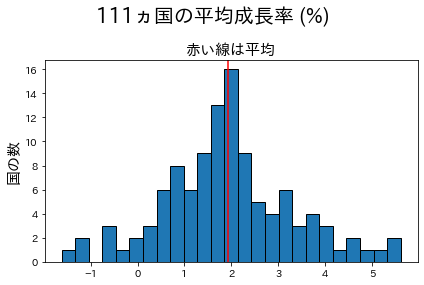

In [18]:
growth_average = df_reg.loc[:,'growth'].mean()           # (1)

fig, ax = plt.subplots(tight_layout=True)
ax.hist('growth', data=df_reg, bins=25, edgecolor='k')   # (2)
ax.axvline(growth_average , c='red')                     # (3)
ax.set_ylabel('国の数', size=15)
ax.set_title('赤い線は平均', size=15)                      # (4)
fig.suptitle(f'{len(df_reg)}ヵ国の平均成長率 (%)', size=20) # (5)
pass

```{admonition} コードの説明
(1) 平均成長率の平均を計算し，結果を変数`growth_average`に割り当てている。

(2) `.hist`はヒストグラムをプロットする`ax`のメソッド。
    * 第一引数はプロットしたい列ラベル（ここでは`growth`）
    * `data`は使用する`DataFrame`を指定する（ここでは`df_reg`）
    * `bins`は階級の数を指定する引数（ここでは`25`）
    * `edgecolor`はヒストグラムの棒の枠線の色を指定する引数で，`k`は黒を示す。`black`としても構わない。
(3) `axvline()`は縦の線を引く`ax`のメソッド
    * 第一引数は横軸の値
    * `c`は色を指定する引数
(4) `plt.subplots()`によって「軸」が`ax`に割り当てられるが，「軸」のタイトルを設定する`ax`のメソッドが`.set_title()`。
    * `size`はフォントの大きさを指定する。
(5) `plt.subplots()`によって「キャンバス」が`fig`に割り当てられるが，「キャンバス」のタイトルを設定する`fig`のメソッドが`.suptitle()`。
    * `f-string`を使って`{}`の中に`len(df_reg)`を代入している。
    * `size`はフォントの大きさを指定する。
    
上のヒストグラムは[発展会計と成長会計](chap:5-accounting)の章の「はじめに」で表示したヒストグラムと同じである。そこでは`DataFrame`のメソッド`.groupby`を使っており，それを使うと国ごとの統計量を簡単に計算することができる。詳細については[このサイト](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)を参照するか，「pandas groupby」で検索してみよう。
```

何％の国で平均を下回るか確認してみよう。

In [19]:
( df_reg.loc[:,'growth'] < growth_average ).sum() / len(df_reg)

0.5135135135135135

半分以上の国の成長率は平均より低いことになる。しかし上でも説明したが，キャッチアップが起こっているかは平均の成長率との比較では確認できない。一方で，平均成長率が負の国もあり，それらの国は経済が縮小しており先進国に追いついているとは言えない。では，**平均**で貧しい国は豊かな国に追いついているのだろうか？回帰分析で検討する。

### 回帰分析：1960~2019

(sec:7-regression)=
### 回帰分析：1960~2019

全てのサンプルを使って回帰分析をおこなおうが，回帰式は次のようの設定する。

In [20]:
formula = 'growth ~ gdp_pc1960_log'

左辺は1960~2019年の平均成長率であり，右辺は1960年の一人当たりGDP（対数）である。

In [21]:
res_all = sm.ols(formula, data=df_reg).fit()
print(res_all.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2673      1.130      2.006      0.047       0.027       4.508
gdp_pc1960_log    -0.0420      0.140     -0.299      0.765      -0.320       0.236


`gdp_pc1960_log`の係数はマイナスだが，$p$値が非常に高く統計的有意性はない。また決定係数も非常に小さい。

In [22]:
res_all.rsquared

0.0008199886481219387

結果を図で確認してみよう。

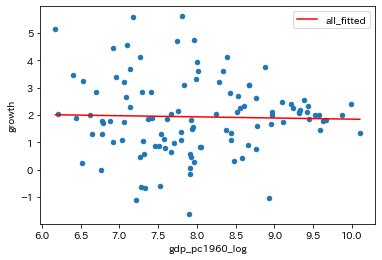

In [23]:
# 予測値の列の作成
df_reg['all_fitted'] = res_all.fittedvalues

# 図示
ax_ = df_reg.plot(x='gdp_pc1960_log', y='growth', kind='scatter')
df_reg.sort_values('all_fitted').plot(x='gdp_pc1960_log', y='all_fitted', color='red', ax=ax_)

pass

これらの結果から，データに含まれる全ての国で無条件所得収斂（キャッチアップ）が成立しているとは言い難い。しかし[所得分布の推移](sec:7-distribution)からキャッチアップを示唆する結果を得たば，結果の差はどこから来ているのだろうか。一つの可能性は分析の中で使った国数でり，次節ではその点について考察する。

### 期間を変えて回帰分析

[所得分布の推移](sec:7-distribution)で示した所得分布の歪度の変化の図を見ると，1970年以降は減少傾向にある。この結果はキャッチアップを示唆する結果であるが，それ以前は分析に含まれた国数の変化により，解釈が難しくなった。同様に，国数の影響が回帰分析の結果に現れている可能性が残る。それを確認するために，回帰分析を次のように期間を変えて`for`ループで計算してみることにしよう。
* 1950~2019年
* 1951~2019年
* ・・・
* ・・・
* 1980~2019年
* ・・・
* ・・・
* 2008~2019年
* 2009~2019年

次の３つのステップに分けてコードを書いていく。
1. 引数`yr`に初期時点の一人当たりGDPの年（例えば，1980）を指定すると，次の４つを返す`growth_regression(yr)`という関数を作成する。
    * 初期時点の一人当たりGDP（対数）の係数の推定値
    * $p$値
    * 決定係数
    * 標本に含まれる国数
1. `for`ループで`growth_regression(yr)`を使い，上の４つの変数の推移を示す変数からなる`DataFrame`を作成する。
1. ４つの変数の時系列プロット

ステップ１の`growth_regression(yr)`は基本的に[](sec:7-regression)で使ったコードを関数としてまとめることで作成する。

In [24]:
def growth_regression(yr):

    # 変数リスト
    var = ['countrycode','rgdpna','pop','cgdpe']    
    
    # 初期の変数を抽出
    cond0 = ( df.loc[:,'year'] == yr )
    df0 = df.loc[cond0, var] \
            .rename(columns={'rgdpna':'rgdpna0',
                             'cgdpe': 'cgdpe0',
                             'pop':   'pop0'})
    # 2019年の変数を抽出
    cond2019 = ( df.loc[:,'year']==2019 )
    df2019 = df.loc[cond2019, var[:-1]] \
               .rename(columns={'rgdpna':'rgdpna2019',
                                'pop':'pop2019'})
    # DataFrameの結合
    df0 = df0.merge(df2019, on='countrycode')
    
    # 初期の一人当たりGDP（対数）
    df0['gdp_pc0_log'] = np.log( df0['cgdpe0']/df0['pop0'] )

    # 初期の一人当たりGDP（成長率計算用）
    df0['gdp_pc0_for_grow'] = df0['rgdpna0']/df0['pop0']

    # 2019年の一人当たりGDP（成長率計算用）
    df0['gdp_pc2019_for_grow'] = df0['rgdpna2019']/df0['pop2019']

    # それぞれの国の平均成長率
    df0['growth'] = 100 *( ( df0['gdp_pc2019_for_grow']/df0['gdp_pc0_for_grow']
                           )**(1/(2019-yr+1))-1
                         )

    # 列 growthとcgdpe0 に欠損値がある行は削除
    df0 = df0.dropna(subset=['growth','cgdpe0'])

    # 
    formula = 'growth ~ gdp_pc0_log'
    res = sm.ols(formula, data=df0).fit()
    
    return ( res.params[1],   # 推定値
             res.pvalues[1],  # p値
             res.rsquared,    # 決定係数
             int(res.nobs) )  # 国の数

`yr=1960`として関数を実行してみよう。

In [25]:
growth_regression(1960)

(-0.04198401871441757, 0.7654443398976624, 0.0008199886481219387, 111)

返り値は４つの値のタプルとなっており，[](sec:7-regression)の結果と同じになることが確認できる。

ステップ２として，`for`ループを使って４つの変数からなる`DataFrame`を作成する。

In [26]:
bhat_list = []       # (1)
pval_list = []       # (2)
rsquared_list = []   # (3)
nobs_list = []       # (4)
yr_list = []         # (5)

for yr in range(1950, 2010):    # (6)
    v = growth_regression(yr)   # (7)
    bhat_list.append(v[0])      # (8)
    pval_list.append(v[1])      # (9)
    rsquared_list.append(v[2])  # (10)
    nobs_list.append(v[3])      # (11)
    yr_list.append(yr)          # (12)

# (13)
df_reg_result = pd.DataFrame({'初期時点の一人当たりGDPの係数':bhat_list,
                              'p値':pval_list,
                              '決定係数':rsquared_list,
                              '国の数':nobs_list},
                              index=yr_list)

```{admonition} コードの説明
(1) 初期の一人当たりGDP（対数）の係数の推定値を格納する空のリスト

(2) p値を格納する空のリスト

(3) 決定係数を格納する空のリスト

(4) 標本の大きさ（国数）を格納する空のリスト

(5) 回帰分析で初期時点の`year`を格納する空のリスト

(6) 1950-2009年を初期時点とする`for`ループの開始

(7) `growth_regression(yr)`を使い`yr`を初期時点として回帰分析を行う。返り値の４つの変数からなるタプルを`v`に割り当てる。

(8) `v`の0番目の要素（推定値）を`bhat_list`に追加する。

(9) `v`の1番目の要素（p値）を`pval_list`に追加する。

(10) `v`の2番目の要素（決定係数）を`rsquared_list`に追加する。

(11) `v`の3番目の要素（標本のサイズ; 国数）を`nobs_list`に追加する。

(13) `for`ループの結果を使い`DataFrame`を作成し`df_reg_result`に割り当てる。
```

ステップ３として`df_reg_result`のメソッド`.plot()`を使い時系列データをプロットする。

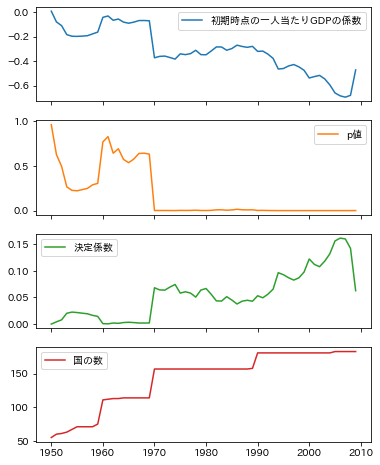

In [27]:
df_reg_result.plot(subplots=True, figsize=(6,8))
pass

上から一番目の図から，初期の一人当たりGDPの係数の推定値は全て負の値となることがわかる。しかし二番目の図からわかるように，1970年までの推定値の統計的優位性低く，1970年以降は高いように見える。1970以降だけを表示してみよう。

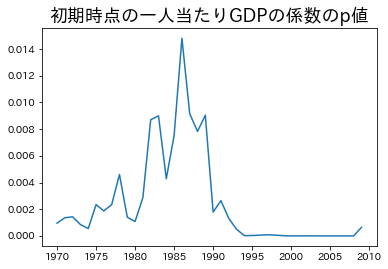

In [28]:
ax_ = df_reg_result.loc[1970:,'p値'].plot()
ax_.set_title('初期時点の一人当たりGDPの係数のp値', size=18)
pass

推定値は0となる帰無仮説を5%の優位水準で棄却できる。即ち，1970年以降は絶対的所得収斂が成立しており，平均して貧しい経済は豊かな経済にキャッチアップしている。この結果は，[所得分布の推移](sec:7-distribution)で示した所得分布の歪度の変化の図と整合性があると言える。